In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/Colab Notebooks/IT401_Project/"

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/IT401_Project


In [2]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import os, sys
import pickle, functools, operator
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# from keras.preprocessing.sequence import pad_sequences
import joblib
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime

In [4]:
TRAIN_LABEL_PATH = os.path.join('', 'training_hindi_label.json')
with open(TRAIN_LABEL_PATH) as data_file:    
    y_data = json.load(data_file)
print(y_data[0])

{'caption': ['एक महिला घोड़े के नीचे जाती है।', 'एक महिला घोड़े के नीचे रेंगती है और उसे एक सरप्राइज मिलता है।', 'एक लड़की घोड़े की पिछली टांगों के बीच से अपना सिर बाहर निकाल रही है जो उसके सिर पर थूकता है।', 'एक महिला के सिर पर एक घोड़ा मल गया।', 'एक घोड़ा एक महिला के सिर पर मलत्याग करता है क्योंकि वह आगे और पीछे के पैरों के बीच में आ जाती है और अपना सिर बाहर निकाल लेती है।', 'एक महिला के सिर पर एक घोड़ा शौच कर रहा है।', 'एक घोड़ा महिला पर वार करता है।', 'एक घोड़ा महिला पर वार करता है।', 'एक महिला को इसलिए शिकार बनाया गया क्योंकि वह घोड़े की पूंछ के सिरे के नीचे थी।', 'एक महिला घोड़े के नीचे रेंगती है और जब वह अपना सिर घोड़ों के पिछले पैरों के बीच चिपकाती है तो घोड़ा उसके सिर पर मल त्याग देता है।', 'एक महिला घोड़े की पीठ के नीचे जाती है और शिकार करती है।', 'एक महिला घोड़े के नीचे जाती है।', 'एक महिला घोड़े के नीचे रेंग रही है।', 'एक महिला को घोड़े द्वारा कुचला जा रहा है।', 'एक महिला घोड़े की टांगों के बीच चल रही है।', 'एक महिला घोड़े के नीचे चल रही है और वह उसके सिर पर वार करता है।', 

In [5]:
y_data[1]

{'caption': ['एक आदमी कटोरी में मक्खन काट रहा है।',
  'एक आदमी ने एक पैन में मक्खन काटा।',
  'एक आदमी मिक्सिंग बाउल में मक्खन काट रहा है।',
  'एक आदमी एक बर्तन में मक्खन काट रहा है।',
  'एक आदमी मक्खन काट रहा है।',
  'एक आदमी मिक्सिंग बाउल में मक्खन के टुकड़े काट रहा है।',
  'एक आदमी मिक्सिंग बाउल में मक्खन के टुकड़े काट रहा है।',
  'एक आदमी बिजली के मिक्सर में मक्खन काट रहा है।',
  'एक आदमी मक्खन काट रहा है।',
  'एक आदमी मक्खन के कुछ टुकड़े काट रहा है और उसे एक स्टील के कटोरे में डाल रहा है।',
  'एक आदमी एक मिक्सिंग बाउल में मक्खन डालता है।',
  'एक व्यक्ति फूड प्रोसेसर में बटर चंक्स डाल रहा है।',
  'एक व्यक्ति खाने को काटकर मिक्सर में डाल देता है।',
  'एक प्याले में मक्खन डाला जा रहा है।',
  'मिक्सर में मक्खन डाला जा रहा है.',
  'स्टैंड मिक्सर में मक्खन के टुकड़े डाले जाते हैं।',
  'किसी को मिक्सिंग बाउल में एक छोटी वर्गाकार वस्तु डालते हुए दिखाया गया है।',
  'उस आदमी ने एक कटोरे में मक्खन काटा।',
  'आदमी मक्खन काट रहा है।',
  'एक व्यक्ति एक बर्तन में मक्खन डाल रहा है।'],
 'id': 'IBgs

In [6]:
train_path = "Data/training_data"
test_path = "Data/testing_data"
batch_size = 320
learning_rate = 0.0007
epochs = 15
latent_dim = 512
num_encoder_tokens = 4096
num_decoder_tokens = 1500
time_steps_encoder = 80
max_probability = -1
save_model_path = 'model_final_hindi'
validation_split = 0.15
max_length = 15
search_type = 'greedy'

In [7]:
TRAIN_LABEL_PATH = os.path.join('', 'training_hindi_label.json')
print(TRAIN_LABEL_PATH)
# mentioning the train test split
train_split = 0.85
# loading the json file for training
with open(TRAIN_LABEL_PATH) as data_file:    
    y_data = json.load(data_file)
# train_list contains all the captions with their video ID
# vocab_list contains all the vocabulary from training data
train_list = []
vocab_list = []
for y in y_data:
  for caption in y['caption']:
    caption = "<bos> " + caption + " <eos>"
    # we are only using sentences whose length lie between 6 and 15
    if len(caption.split())>10 or len(caption.split())<6:
      continue
    else:
      train_list.append([caption, y['id']])
print(len(train_list))
random.shuffle(train_list)
training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split):]
for train in training_list:
    vocab_list.append(train[0])
# Tokenizing the words and using most frequent 1500
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)
print(len(tokenizer.word_index))
x_data = {}
TRAIN_FEATURE_DIR = os.path.join(train_path, 'feat')
# Loading all the numpy arrays at once and saving them in a dictionary
for filename in os.listdir(TRAIN_FEATURE_DIR):
    f = np.load(os.path.join(TRAIN_FEATURE_DIR, filename))
    x_data[filename[:-4]] = f
print(len(training_list))
#print(training_list)
print(len(validation_list))
len(x_data)

training_hindi_label.json
14494
3501
12319
2175


1450

In [8]:
 #Creating a custom data generator because we cannot load so many files at once
def load_datatest(train_path, epochs=100, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=1500,training_list=train_list, batch_size=32, maxlen=10):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)
    max_seq_length = train_sequences.shape[1]
    filesize = len(train_sequences)
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    for i in range(epochs):
      for idx in  range(0,filesize):
        n += 1
        encoder_input_data.append(x_data[videoId[idx][:-4]])
        y = to_categorical(train_sequences[idx], num_decoder_tokens)
        decoder_input_data.append(y[:-1])
        decoder_target_data.append(y[1:])
        if n == batch_size:
          encoder_input = np.array(encoder_input_data)
          decoder_input = np.array(decoder_input_data)
          decoder_target = np.array(decoder_target_data)
          encoder_input_data = []
          decoder_input_data = []
          decoder_target_data = []
          n = 0
          yield ([encoder_input, decoder_input], decoder_target)

In [9]:
# writing the train and validation generator
train = load_datatest(train_path='training data',batch_size=320, training_list=training_list, x_data=x_data, epochs=100)
valid = load_datatest(train_path='training data',batch_size=320, training_list=validation_list, x_data=x_data, epochs=100)

In [10]:
"""
time_steps_encoder is the number of frames per video we will be using for training
num_encoder_tokens is the number of features from each frame
latent_dim is the number of hidden features for lstm
time_steps_decoder is the maximum length of each sentence
num_decoder_tokens is the final number of tokens in the softmax layer
batch size
"""
time_steps_encoder=80
num_encoder_tokens=4096
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320
epochs=100

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 80, 4096)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 10, 1500)]   0           []                               
                                                                                                  
 endcoder_lstm (LSTM)           [(None, 80, 512),    9439232     ['encoder_inputs[0][0]']         
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

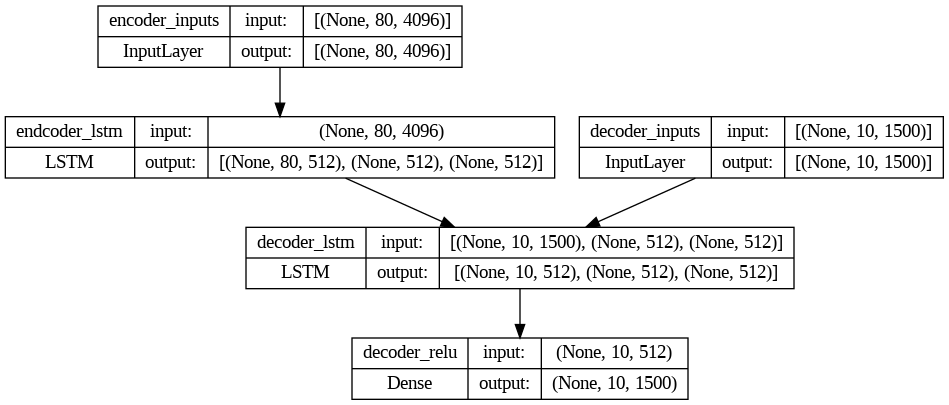

In [11]:
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train_hindi.png', show_shapes=True, show_layer_names=True)

In [12]:
#x_data
from tensorflow.keras import backend as K
K.clear_session()

In [13]:
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = keras.optimizers.Adam(lr = 0.0003)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')


try:
    model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=epochs, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])
except KeyboardInterrupt:
    print("\nW: interrupt received, stopping")
finally:
    pass

<ipython-input-8-46021482b203>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_sequences = np.array(train_sequences)


Epoch 1/100
38/38 [==============================] - 53s 1s/step - loss: 3.8938 - accuracy: 0.3033 - val_loss: 3.2016 - val_accuracy: 0.3755 - lr: 0.0010
Epoch 2/100
38/38 [==============================] - 39s 1s/step - loss: 3.1109 - accuracy: 0.3824 - val_loss: 2.9100 - val_accuracy: 0.4188 - lr: 0.0010
Epoch 3/100
38/38 [==============================] - 39s 1s/step - loss: 2.8195 - accuracy: 0.4379 - val_loss: 2.6623 - val_accuracy: 0.4859 - lr: 0.0010
Epoch 4/100
38/38 [==============================] - 38s 1s/step - loss: 2.5059 - accuracy: 0.5249 - val_loss: 2.3669 - val_accuracy: 0.5638 - lr: 0.0010
Epoch 5/100
38/38 [==============================] - 38s 1s/step - loss: 2.1990 - accuracy: 0.5792 - val_loss: 2.1423 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 6/100
38/38 [==============================] - 38s 990ms/step - loss: 1.9811 - accuracy: 0.6132 - val_loss: 1.9717 - val_accuracy: 0.6216 - lr: 0.0010
Epoch 7/100
38/38 [==============================] - 38s 1s/step - loss: 

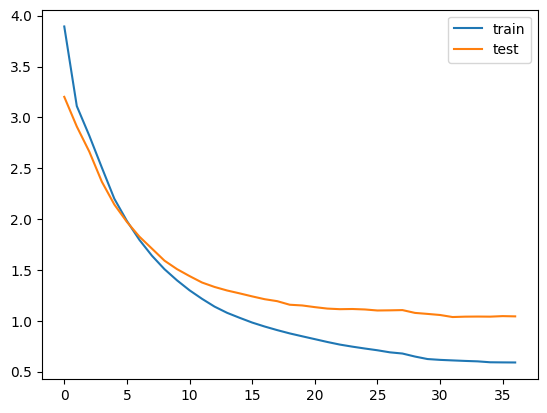

In [14]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('loss_hindi.png')
plt.show()

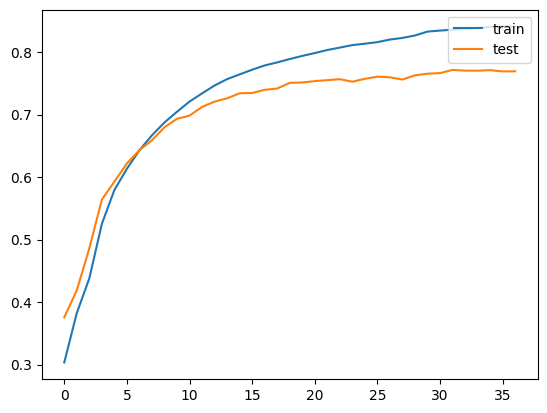

In [15]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('accuracy_hindi.png')
plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 80, 4096)]       0         
                                                                 
 endcoder_lstm (LSTM)        [(None, 80, 512),         9439232   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 9,439,232
Trainable params: 9,439,232
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 10, 1500)]   0           []                               
 

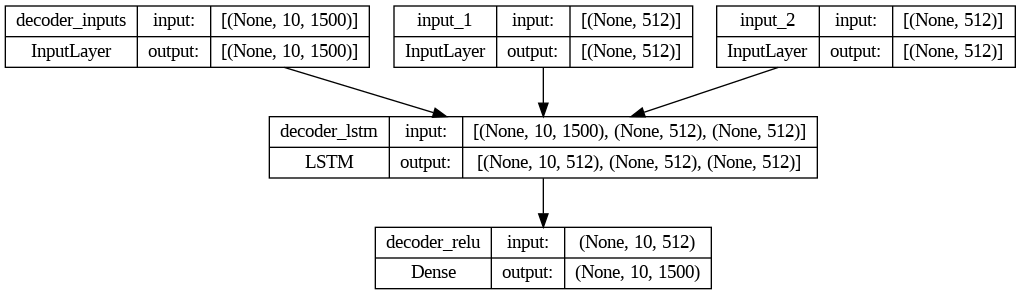

In [16]:
save_model_path = 'model_final_hindi'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model_hindi.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights_hindi.h5'))
with open(os.path.join(save_model_path,'tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)
plot_model(encoder_model, to_file='model_inference_encoder_hindi.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder_hindi.png', show_shapes=True, show_layer_names=True)

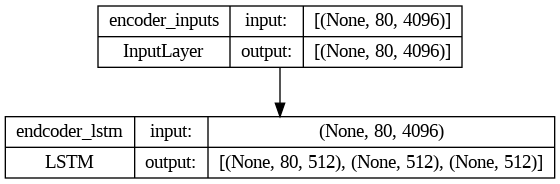

In [17]:
plot_model(encoder_model, to_file='model_inference_encoder_hindi.png', show_shapes=True, show_layer_names=True)

In [4]:
# class to perform inference on all test files and save as test_output.txt
class Video2Text(object):
    ''' Initialize the parameters for the model '''
    def __init__(self):
        self.latent_dim = 512
        self.num_encoder_tokens = 4096
        self.num_decoder_tokens = 1500
        self.time_steps_encoder = 80
        self.time_steps_decoder = None
        self.preload = True
        self.preload_data_path = 'preload_data'
        self.max_probability = -1

        # processed data
        self.encoder_input_data = []
        self.decoder_input_data = []
        self.decoder_target_data = []
        self.tokenizer = None

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None
        self.save_model_path = 'model_final_hindi'
        self.test_path = 'Data/testing_data'
    def load_inference_models(self):
        # load tokenizer
        
        with open(os.path.join(self.save_model_path, 'tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)
        # inference encoder model
        self.inf_encoder_model = load_model(os.path.join(self.save_model_path, 'encoder_model_hindi.h5'))

        # inference decoder model
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens))
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax')
        decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True)
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.inf_decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        self.inf_decoder_model.load_weights(os.path.join(self.save_model_path, 'decoder_model_weights_hindi.h5'))
    
    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value,[],[],0)
        return decode_seq
    def beam_search(self, target_seq, states_value, prob,  path, lens):
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape((self.num_decoder_tokens))
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 10
            if(sampled_char != 'eos' and lens <= MAX_LEN):
                p = output_tokens[sampled_token_index[i]]
                if(sampled_char == ''):
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens+1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if(p > self.max_probability):
                    decode_seq = path
                    self.max_probability = p
    def decoded_sentence_tuning(self, decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        unigram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in unigram:
                unigram[c] += 1
            else:
                unigram[c] = 1
            if(last_string == c and idx2 > 0):
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def get_test_data(self, path):
        X_test = []
        X_test_filename = []
        with open (os.path.join('', 'testing_ids.txt')) as testing_file:
            lines = testing_file.readlines()
            for filename in lines:
                filename = filename.strip()
                # print(filename)
                f = np.load(os.path.join(path , 'feat', filename[0:-4] + '.npy'))
                X_test.append(f)
                X_test_filename.append(filename[:-4])
            X_test = np.array(X_test)
        return X_test, X_test_filename

    def test(self):
        X_test, X_test_filename = self.get_test_data(os.path.join(self.test_path))
        # print(len(X_test), len(X_test_filename))
        # generate inference test outputs
        with open(os.path.join(self.save_model_path, 'test_hindi_output.txt'), 'w') as file:
            for idx, x in enumerate(X_test):
                print(X_test_filename[idx])
                file.write(X_test_filename[idx]+',')
                decoded_sentence = self.decode_sequence2bs(x.reshape(-1, 80, 4096))
                decode_str = self.decoded_sentence_tuning(decoded_sentence)
                for d in decode_str:
                    file.write(d + ' ')
                # print(X_test_filename)
                # print(decode_str)
                file.write('\n')
                # re-init max prob
                self.max_probability = -1

In [7]:
c = Video2Text()
c.load_inference_models()
c.test()

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 71ms/step
TZ860P4iTaM_15_28
1/1 [==============================] - 0s 45ms/step
lo4KcsBN--A_0_10
1/1 [==============================] - 0s 33ms/step
u4T76jsPin0_0_11
1/1 [==============================] - 0s 86ms/step
7HcYJKMxpcg_20_28
1/1 [==============================] - 0s 43ms/step
CGllPWAwmUo_1_15
1/1 [==============================] - 0s 30ms/step
WTf5EgVY5uU_124_128
1/1 [==============================] - 0s 53ms/step


In [9]:
FileasList=[]
with open("model_final_hindi/test_hindi_output.txt", "r") as file1:
    FileasList = file1.readlines()
    for i in FileasList:
      print(i)

ScdUht-pM6s_53_63,एक आदमी कुछ पका रहा है। 

wkgGxsuNVSg_34_41,एक बच्चा से पीता है। 

BtQtRGI0F2Q_15_20,एक आदमी दौड़ रहा है। 

k06Ge9ANKM8_5_16,एक आदमी कुछ बिस्तर बना रहा है। 

sZf3VDsdDPM_107_114,एक आदमी अपने पकड़े को है। 

shPymuahrsc_5_12,एक बिल्ली एक बच्चे पर हमला करती है। 

XOAgUVVwKEA_8_20,एक बच्चा एक बच्चा बैठा है। 

ufFT2BWh3BQ_0_8,एक पांडा भालू के साथ खेल रहा है। 

5YJaS2Eswg0_22_26,कोई बंदूक चला रहा है। 

lw7pTwpx0K0_38_48,एक आदमी एक आदमी और डालता है। 

UbmZAe5u5FI_132_141,एक व्यक्ति झींगा काट रहा है। 

xCFCXzDUGjY_5_9,एक आदमी फुटबॉल खेल रहा है। 

He7Ge7Sogrk_47_70,एक आदमी पुल कर रहा है। 

tJHUH9tpqPg_113_118,एक महिला कुछ सामग्री मिला रही है। 

n016q1w8Q30_2_11,एक महिला ने है। 

RjpbFlOHFps_8_25,एक आदमी समुद्र तट पर खेल रहा है। 

6JnGBs88sL0_4_10,एक महिला अपने से नीचे है। 

EpMuCrbxE8A_107_115,एक आदमी अपना बना रहा है। 

HAjwXjwN9-A_16_24,एक बच्चा एक पर दौड़ रहा है। 

4xVGpDmA4lE_23_33,एक आदमी एक आदमी चल रहा है। 

k5OKBX2e7xA_19_32,एक आदमी सड़क पर स्टंट करता है। 

Jag7oTemldY_1

In [10]:
import math
import operator
import sys
import json
from functools import reduce 
def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def BLEU(s,t,flag = False):

    score = 0.  
    count = 0
    candidate = [s.strip()]
    if flag:
        references = [[t[i].strip()] for i in range(len(t))]
    else:
        references = [[t.strip()]] 
    precisions = []
    pr, bp = count_ngram(candidate, references, 1)
    precisions.append(pr)
    score = geometric_mean(precisions) * bp
    return score
### Usage: python bleu_eval.py caption.txt
### Ref : https://github.com/vikasnar/Bleu
if __name__ == "__main__" :
    test = json.load(open('testing_hindi_label.json','r'))
    # output = sys.argv[1]
    result = {}
    with open("model_final_hindi/test_hindi_output.txt",'r') as f:
        for line in f:
            line = line.rstrip()
            comma = line.index(',')
            test_id = line[:comma]
            caption = line[comma+1:]
            result[test_id] = caption
    #count by average
    bleu=[]
    for item in test:
        score_per_video = []
        for caption in item['caption']:
            caption = caption.rstrip('.')
            # print(result[item['id'][:-4]])

            score_per_video.append(BLEU(result[item['id'][:-4]],caption))
        bleu.append(sum(score_per_video)/len(score_per_video))
    average = sum(bleu) / len(bleu)
    print("Originally, average bleu score is " + str(average))
    bleu=[]
    for item in test:
        score_per_video = []
        captions = [x.rstrip('.') for x in item['caption']]
        score_per_video.append(BLEU(result[item['id'][:-4]],captions,True))
        bleu.append(score_per_video[0])
    average = sum(bleu) / len(bleu)
    print("By another method, average bleu score is " + str(average))

Originally, average bleu score is 0.27423736585844394
By another method, average bleu score is 0.6316340777288404


In [11]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[10].split(",")[0]+".avi" 
print("Caption : "+FileasList[10].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[20].split(",")[0]+".avi" 
print("Caption : "+FileasList[20].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

Output hidden; open in https://colab.research.google.com to view.

In [13]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[25].split(",")[0]+".avi" 
print("Caption : "+FileasList[25].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[30].split(",")[0]+".avi" 
print("Caption : "+FileasList[30].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

Caption : एक आदमी रोटी काट रहा है। 

Data/testing_data/video/mtrCf667KDk_134_176.avi
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t: 100%|██████████| 1260/1260 [00:10<00:00, 160.41it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.9/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file Data/testing_data/video/mtrCf667KDk_134_176.avi, 921600 bytes wanted but 0 bytes read,at frame 1259/1260, at time 42.01/42.01 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[35].split(",")[0]+".avi" 
print("Caption : "+FileasList[35].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

In [ ]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[50].split(",")[0]+".avi" 
print("Caption : "+FileasList[50].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

In [ ]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[90].split(",")[0]+".avi" 
print("Caption : "+FileasList[90].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

In [ ]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[80].split(",")[0]+".avi" 
print("Caption : "+FileasList[80].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

In [ ]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[70].split(",")[0]+".avi" 
print("Caption : "+FileasList[70].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)

In [ ]:
from moviepy.editor import *
path="Data/testing_data/video/"+FileasList[60].split(",")[0]+".avi" 
print("Caption : "+FileasList[60].split(",")[1])
print(path)
clip=VideoFileClip(path)
clip.ipython_display(width=280)